The original agent does not hand over control to the tool agent, instead it runs as a function call. 


references: 
- https://openai.github.io/openai-agents-python/tools/#agents-as-tools

In [23]:
from dotenv import load_dotenv
from agents import (

    Agent,
    Runner,
    RunConfig,
    trace,
    ModelSettings,
)
load_dotenv()


True

In [24]:

from helpers.trace_util import get_trace_url

from helpers.model_client import (
    get_openai_client,
    get_github_model_provider
)

model_name = "gpt-4o-mini"

GITHUB_MODEL_PROVIDER = get_github_model_provider(
    client = get_openai_client(),
    model = model_name
)


## Define the Agents

Here we will define two Agents that are capable of translating text. 

There is no special struture to the inputs or outputs in this exampl. But it is recommended to use Structured Outputs, this approah is more robust for integration betweeen agents and external systems 

In [6]:
spanish_agent = Agent(
    name="Spanish agent",
    instructions="You translate the user's message to Spanish",
    model=model_name,

)

french_agent = Agent(
    name="French agent",
    instructions="You translate the user's message to French",
    model=model_name
)


The orchestrator is in control and resposible for executing the LLM task. It leverges tools and tool/agents as demostratred previously in the agents with [tools example](04_agents_with_tools.ipynb). 

In [19]:

orchestrator_agent = Agent(
    name="orchestrator_agent",
    model=model_name,
    instructions=(
        "You are a translation agent. You use the tools given to you to translate."
        "If asked for multiple translations, you call the relevant tools."
        "You only speak English. Do not translate the user's message yourself."
        "You can use the tools to translate the user's message."
    ),
    tools=[
        spanish_agent.as_tool(
            tool_name="translate_to_spanish",
            tool_description="Translate the user's message to Spanish",
        ),
        french_agent.as_tool(
            tool_name="translate_to_french",
            tool_description="Translate the user's message to French",
        ),
    ],
    tool_use_behavior="run_llm_again",
)

## Execute the workflow

In [34]:
orchestrator_agent.model

'gpt-4o-mini'

In [33]:
try:
    result = None
    with trace(workflow_name="translation_agent_as_tools", group_id="mdsi") as tr:
        print("Trace URL:", get_trace_url(tr))
        result = await Runner.run(
            orchestrator_agent,
            "How to say Greetings in French, how many other languages can you say greetings in? can you also say greetings in Spanish?",
            run_config=RunConfig(
                model=model_name,
                model_provider=GITHUB_MODEL_PROVIDER,
                model_settings=ModelSettings(**{
                    "max_tokens": 3000,
                }),
                ),



        )
except Exception as e:
    print(f"Error: {e}")
finally:
    print(result)


Trace URL: https://platform.openai.com/traces/trace?trace_id=trace_1534676abe5b42d89ca27164c83f9f80
RunResult:
- Last agent: Agent(name="orchestrator_agent", ...)
- Final output (str):
    In French, "Greetings" is translated as "Salutations." In Spanish, it is translated as "Saludos."
- 5 new item(s)
- 2 raw response(s)
- 0 input guardrail result(s)
- 0 output guardrail result(s)
(See `RunResult` for more details)


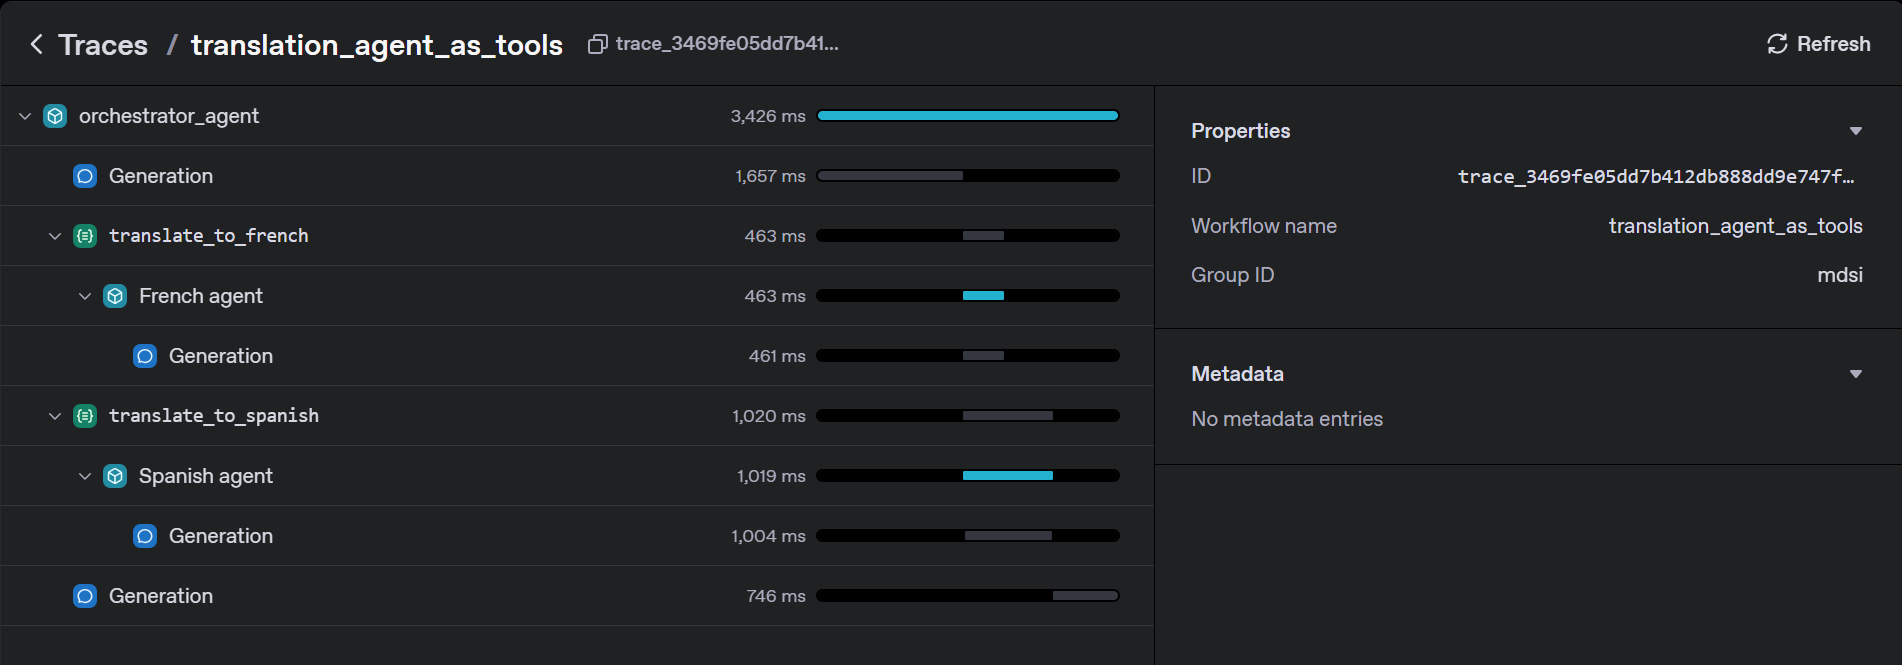

## Visualise the Agent

In [35]:
from agents.extensions.visualization import draw_graph

try:
    draw_graph(orchestrator_agent, filename="viz/06_agent_as_tool.gv")
except Exception as e:
    print(f"An error occurred: {e}")

An error occurred: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH
